In [1]:
import warnings
from copy import deepcopy

import dill
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import polars as pl
from catboost import CatBoostClassifier, Pool
from dataset import Dataset
from joblib import Parallel, delayed, dump, load
from matplotlib.gridspec import GridSpec
from metrics import gini_stability, metrics_estimation
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.ensemble import StackingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (
    StratifiedGroupKFold,
    StratifiedKFold,
    train_test_split,
)
from sklearn.utils.validation import check_is_fitted
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, Dataset as lgb_Dataset

RAND = 0
N_FOLDS = 5
warnings.filterwarnings("ignore")

In [2]:
df_train = pl.read_parquet("dataframe.parquet")
X = df_train.to_pandas()
X.set_index("case_id", inplace=True)
del df_train
weeks = X.pop("WEEK_NUM")
y = X.pop("target")
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()

In [3]:
imputer_cat = SimpleImputer(missing_values=None, strategy="constant", fill_value="None")
X[cat_features] = imputer_cat.fit_transform(X[cat_features], y)
X[cat_features] = X[cat_features].astype("category")

In [4]:
X_train, X_test, y_train, y_test, weeks_train, weeks_test = train_test_split(
    X, y, weeks, test_size=0.2, stratify=y, shuffle=True, random_state=RAND
)

X_train_, X_val, y_train_, y_val, weeks_train_, weeks_val = train_test_split(
    X_train,
    y_train,
    weeks_train,
    test_size=0.16,
    stratify=y_train,
    shuffle=True,
    random_state=RAND,
)
scale_pos_weight = float(np.sum(y_train_ == 0)) / np.sum(y_train_ == 1)
eval_set = [(X_val, y_val)]

In [5]:
best_params = {}
for study_name in ["cat_boost3", "lgbm21", "xgb12"]:
    study = optuna.load_study(
        storage="sqlite:///{}.db".format(study_name),
        study_name=study_name,
    )
    key = "".join([i for i in study_name if not i.isdigit()])
    best_params[key] = study.best_params
best_params["xgb"]["n_estimators"] = 2000

In [6]:
params = {
    "cat_boost": {
        "eval_metric": "CrossEntropy",
        "cat_features": cat_features,
        "boosting_type": "Plain",
        "border_count": 32,
        "od_wait": 20,
        "task_type": "GPU",
    },
    "lgbm": {"n_jobs": 24, "verbose": -1},
    "xgb": {"enable_categorical": True, "device": "cuda"},
}

Составим ансамблевые модели для улучшения результатов по сравнению с базовыми моделями.

# Voting

Заранее обучим классификаторы на лучших параметрах и используем CalibratedClassifierCV с cv="prefit" для калибровки на валидационных данных. Для этого напишем свой класс реализующий VotingClassifier использующий предобученные классификаторы.

In [50]:
tuned_catboost = CatBoostClassifier(
    random_state=RAND,
    scale_pos_weight=scale_pos_weight,
    **params["cat_boost"],
    **best_params["cat_boost"]
)
tuned_catboost.fit(
    X_train_, y_train_, eval_set=eval_set, early_stopping_rounds=100, verbose=0
);

In [51]:
tuned_lgb = LGBMClassifier(
    random_state=RAND,
    scale_pos_weight=scale_pos_weight,
    **params["lgbm"],
    **best_params["lgbm"]
)
tuned_lgb.fit(
    X_train_,
    y_train_,
    eval_set=eval_set,
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=100, verbose=0),
    ],
);

In [52]:
tuned_xgb = XGBClassifier(
    random_state=RAND,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=100,
    eval_metric="auc",
    **params["xgb"],
    **best_params["xgb"]
)
tuned_xgb.fit(X_train_, y_train_, eval_set=eval_set, verbose=0);

In [241]:
with open("tuned_catboost.bin", "wb") as fout:
    dill.dump(tuned_catboost, fout)
with open("tuned_lgb.bin", "wb") as fout:
    dill.dump(tuned_lgb, fout)
with open("tuned_xgb.bin", "wb") as fout:
    dill.dump(tuned_xgb, fout)

In [7]:
baseline_catboost = CatBoostClassifier(
    random_state=RAND, scale_pos_weight=scale_pos_weight, **params["cat_boost"]
)
baseline_catboost.fit(
    X_train_, y_train_, eval_set=eval_set, early_stopping_rounds=100, verbose=0
)
with open("baseline_catboost.bin", "wb") as fout:
    dill.dump(baseline_catboost, fout)

In [175]:
class VotingClassifierCustom(BaseEstimator, ClassifierMixin):
    """Soft Voting classifier for prefitted estimators.

    Parameters
    ----------
    models: list of CalibratedClassifierCV estimators with prefitted estimators
    weights: array-like of shape (n_classifiers,), default=None
        Sequence of weights (`float` or `int`) to weight the occurrences of
        class probabilities before averaging. Uses no weights if `None`.
    """

    def __init__(self, models: list[tuple], weights=None) -> None:
        for model in models:
            assert isinstance(
                model, CalibratedClassifierCV
            ), "All models must be instance of CalibratedClassifierCV with prefitted estimators"
        if weights is not None:
            assert len(weights) == len(
                models
            ), "Shape of weights must be equal to number of models."
        self.models = models
        self.weights = weights

    def fit(self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray) -> object:
        """Fit the estimators.
        Already fitted classifiers will be calibrated via the parameter cv="prefit".
        In this case, no cross-validation is used and all provided data is used for calibration.
        The user has to take care manually that data for model fitting and calibration are disjoint.

        Parameters
        ----------
        X: {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        y: array-like of shape (n_samples,)
            Target values.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        for model in self.models:
            model.fit(X, y)
        return self

    def find_weights(
        self,
        X: pd.DataFrame | np.ndarray,
        y: pd.Series | np.ndarray,
        weeks: pd.Series | np.ndarray,
        method: str = "Powell",
    ) -> None:
        """Find best weights using scipy.minimize

        Parameters
        ----------
        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Target values.

        weeks : array-like of shape (n_samples,)
            groupping feature

        method: str, optional
            Type of solver. Should be one of ‘Nelder-Mead’, ‘Powell’, ‘CG’, ‘BFGS’, ‘L-BFGS-B’,
            ‘TNC’, ‘COBYLA’, ‘SLSQP’, ‘trust-constr’

        Returns
        -------
        None
        """
        pred_cols = [f"pred_{i}" for i in range(len(self.models))]
        bounds = [(0, 1)] * len(pred_cols)
        df = self.base_df(X, y, weeks, pred_cols)
        gini_score_fn = gini_wrapper(df)
        w_searcher = WeightsSearcher(gini_score_fn, bounds, method=method)
        optimized_weights = w_searcher.find_weights(df[pred_cols].to_numpy(), y)
        self.weights = optimized_weights
        return

    def base_df(
        self,
        X: pd.DataFrame | np.ndarray,
        y: pd.Series | np.ndarray,
        weeks: pd.Series | np.ndarray,
        pred_cols: list,
    ) -> pd.DataFrame:
        """Prepare dataframe with predicted scores for weights optimizing.

        Parameters
        ----------
        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Target values.

        weeks : array-like of shape (n_samples,)
            groupping feature

        pred_cols: list
            names of columns

        Returns
        -------
        df : pd.DataFrame
        """
        df = pd.DataFrame()
        for name, model in zip(pred_cols, self.models):
            y_scores = pd.Series(model.predict_proba(X)[:, 1], name=name)
            df = pd.concat([df, y_scores], axis=1)
        df.set_index(X.index, inplace=True)
        df = pd.concat([df, weeks, y], axis=1)
        return df

    def predict(self, X: pd.DataFrame | np.ndarray) -> np.ndarray:
        """Predict class labels for X.

        Parameters
        ----------
        X: {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        y_pred : array-like of shape (n_samples,)
            Predicted class labels.
        """
        y_scores = self.predict_proba(X)
        y_pred = np.argmax(y_scores, axis=1)
        return y_pred

    def predict_proba(self, X: pd.DataFrame | np.ndarray) -> np.ndarray:
        """Compute probabilities of possible outcomes for samples in X.

        Parameters
        ----------
        X: {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        y_scores : array-like of shape (n_samples, n_classes)
            Weighted probability for each class per sample.
        """
        y_scores = []
        for i, model in enumerate(self.models):
            prob = model.predict_proba(X)
            scores = prob if self.weights is None else self.weights[i] * prob
            y_scores.append(scores)
        y_scores = np.sum(y_scores, axis=0)
        return y_scores


def gini_wrapper(base_df: pd.DataFrame) -> callable:
    """Define loss_fn for minimize

    Parameters
    ----------
    base_df: pd.DataFrame
        with predicted scores, weeks and target

    Returns
    -------
    out : callable
    """
    base_df = base_df[["WEEK_NUM", "target"]].copy()

    def gini_wrapper_inner(target: np.ndarray, scores: np.ndarray) -> float:
        base_df["score"] = scores
        gini_score = gini_stability(base_df)
        return 1 - gini_score

    return gini_wrapper_inner


class WeightsSearcher:
    """Find best weights

    Parameters
    ----------
    loss_fn: callable:
        loss function

    bounds: list:
        like [(0, 1), (0, 1), (0, 1)]

    mode : str

    method : str, optional
        Type of solver. Should be one of ‘Nelder-Mead’, ‘Powell’, ‘CG’, ‘BFGS’, ‘L-BFGS-B’,
        ‘TNC’, ‘COBYLA’, ‘SLSQP’, ‘trust-constr’
    """

    def __init__(self, loss_fn, bounds=[], mode: str = "min", method: str = "SLSQP"):
        self.loss_fn = loss_fn
        self.bounds = bounds
        self.mode = mode
        self.method = method

    def _objective_function_wrapper(
        self, y_pred: np.ndarray, y_true: np.ndarray, obj_fn: callable
    ) -> callable:
        """Objective function

        Parameters
        ----------
        y_pred: np.ndarray

        y_true: np.ndarray

        obj_fn: callable

        Returns
        -------
        out : callable
        """

        def objective_function(weights: np.ndarray) -> float:
            pred_weighted = (y_pred * weights).sum(axis=1)
            score = obj_fn(y_true, pred_weighted)
            return score

        return objective_function

    def find_weights(self, val_preds: np.ndarray, y_true: np.ndarray) -> list:
        """Objective function

        Parameters
        ----------
        y_pred: np.ndarray

        y_true: np.ndarray

        Returns
        -------
        optimized_weights : list
        """
        len_models = len(self.bounds)
        bounds = [0, 1] * len_models if len(self.bounds) == 0 else self.bounds
        initial_weights = np.ones(len_models) / len_models
        objective_function = self._objective_function_wrapper(
            val_preds, y_true, self.loss_fn
        )
        result = minimize(
            objective_function,
            initial_weights,
            bounds=bounds,
            method=self.method,
        )
        optimized_weights = result.x
        optimized_weights /= np.sum(optimized_weights)
        return optimized_weights

In [130]:
clb_cat = CalibratedClassifierCV(tuned_catboost, method="isotonic", cv="prefit")
clb_lgb = CalibratedClassifierCV(tuned_lgb, method="isotonic", cv="prefit")
clb_xgb = CalibratedClassifierCV(tuned_xgb, method="isotonic", cv="prefit")
models = [clb_cat, clb_lgb, clb_xgb]

In [180]:
vt_clf_w_auto = VotingClassifierCustom(models)
vt_clf_w_auto.fit(X_val, y_val);

In [181]:
vt_clf_w_auto.find_weights(X_val, y_val, weeks_val, method="Powell")
vt_clf_w_auto.weights

array([0.61501642, 0.10484445, 0.28013913])

In [182]:
metrics = metrics_estimation(
    vt_clf_w,
    X_train_,
    y_train_,
    X_test,
    y_test,
    weeks_train_,
    weeks_test,
    name="Voting_weighted_auto",
)

In [ ]:
w = [1.0, 0.1, 1.0]
vt_clf_w = VotingClassifierCustom(models, w)

In [ ]:
vt_clf_w.fit(X_val, y_val);

In [29]:
metrics_ = metrics_estimation(
    vt_clf_w,
    X_train_,
    y_train_,
    X_test,
    y_test,
    weeks_train_,
    weeks_test,
    name="Voting_weighted",
)
metrics = pd.concat([metrics, metrics_])

In [30]:
vt_clf = VotingClassifierCustom(models)
vt_clf.fit(X_val, y_val);

In [31]:
metrics_ = metrics_estimation(
    vt_clf,
    X_train_,
    y_train_,
    X_test,
    y_test,
    weeks_train_,
    weeks_test,
    name="Voting_no_weights",
)
metrics = pd.concat([metrics, metrics_])

In [185]:
metrics

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,gini_stability,"overfitting, %"
model,,,,,,,,
Voting_weighted_auto_train,0.968692,0.894470,0.618962,0.010728,0.021090,0.102074,0.773653,4.356915
Voting_weighted_auto_test,0.968575,0.857126,0.514085,0.007605,0.014988,0.110082,0.688272,4.356915
Voting_weighted_train,0.968697,0.893210,0.606811,0.012154,0.023831,0.109814,0.770778,4.190239
Voting_weighted_test,0.968542,0.857288,0.482558,0.008647,0.016989,0.116794,0.689036,4.190239
Voting_no_weights_train,0.968654,0.902040,0.649682,0.006325,0.012528,0.120357,0.790379,5.396866
Voting_no_weights_test,0.968588,0.855851,0.550000,0.004584,0.009092,0.128851,0.684912,5.396866


Voting c весами показывает результаты чуть лучше чем без весов. Автоматический поиск весов не оказался лучше ручного выбора. Трудность в том, что эти веса еще нужно подобрать не увеличив переобучение. По сравнению со значением gini_stability=0.689616	для одного CatBoost с лучшими гиперпараметрами, Voting не позволяет получить результаты лучше.

# Blending

In [33]:
class BlendingClassifier(BaseEstimator, ClassifierMixin):
    """Blending Ensemble classifier of multiple estimators and meta estimator.

    Parameters
    ----------
    estimators : list
        Base estimators which will be stacked together.
        The type of estimator is generally expected to be a classifier.
    final_estimator : estimator, default=None
        A classifier which will be used to combine the base estimators.
        The default classifier is a LogisticRegression.
    stack_method : {'predict_proba', 'predict'}, default='predict_proba'
        Methods called for each base estimator. It can be:
        'predict_proba'  or 'predict'
    n_jobs : int, default=-1
        The number of jobs to run in parallel all `estimators` `fit`.
         -1 means using all processors.
         None means use number of base estimators
    """

    def __init__(
        self,
        estimators: list,
        final_estimator=None,
        stack_method: str = "predict_proba",
        n_jobs: int | None = None,
    ):
        assert len(estimators) > 1, "More than 1 estimators must be passed."
        self.estimators = estimators
        self.__estimators_train = None
        self.__estimators_val = None
        self.final_estimator = (
            LogisticRegression(class_weight="balanced", n_jobs=-1)
            if final_estimator is None
            else final_estimator
        )
        self.n_jobs = len(estimators) if n_jobs is None else n_jobs
        self.stack_method = stack_method

    def __sklearn_is_fitted__(self) -> bool:
        """Perform is_fitted validation for final estimator.

        Returns
        -------
        out: bool
        """
        return check_is_fitted(self.final_estimator)

    def _fit_base_estimators(
        self,
        X: pd.DataFrame | np.ndarray,
        y: pd.Series | np.ndarray,
        on_train: bool = True,
    ) -> None:
        """Fit base estimators.

        Parameters
        ----------
        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Target values.

        on_train : bool, default=True
            fit __estimators_train on train data if True
            or __estimators_val on validation data if False

        Returns
        -------
        None
        """
        fitted_estimators = Parallel(n_jobs=self.n_jobs)(
            delayed(est.fit)(X, y) for est in deepcopy(self.estimators)
        )
        if on_train:
            self.__estimators_train = fitted_estimators
        else:
            self.__estimators_val = fitted_estimators
        return

    def _meta_X(
        self, X: pd.DataFrame | np.ndarray, on_train: bool = True
    ) -> pd.DataFrame:
        """Generate meta data using fitted base estimators

        Parameters
        ----------
        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        on_train : bool, default=True
            predict using self.__estimators_train if True
            or self.__estimators_val if False

        Returns
        -------
        meta_X : pd.DataFrame
            Meta data for meta estimator
        """
        estimators = self.__estimators_train if on_train else self.__estimators_val
        assert self.stack_method in [
            "predict_proba",
            "predict",
        ], "stack_method not passed"
        if self.stack_method == "predict_proba":
            X_pred = (delayed(self.proba)(est, X) for est in estimators)
        elif self.stack_method == "predict":
            X_pred = (delayed(est.predict)(X) for est in estimators)
        X_pred = Parallel(n_jobs=self.n_jobs)(X_pred)
        meta_X = pd.DataFrame(X_pred).T
        return meta_X

    def _meta_data_train(
        self,
        X: pd.DataFrame | np.ndarray,
        y: pd.Series | np.ndarray,
        test_size: float = 0.15,
        random_state: int = 0,
    ) -> tuple:
        """
        Get meta data for train.

        Parameters
        ----------
        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        y: array-like of shape (n_samples,)
            Target values.

        test_size: float, default=0.15
            For train_test_split.

        random_state: int, default=0
            For train_test_split.

        Returns
        -------
        out : tuple of meta_X, meta_y
            Meta data
        """
        X_train_, X_val, y_train_, y_val = train_test_split(
            X,
            y,
            stratify=y,
            test_size=test_size,
            random_state=random_state,
            shuffle=True,
        )
        self._fit_base_estimators(X_train_, y_train_, on_train=True)
        self._fit_base_estimators(X_val, y_val, on_train=False)
        meta_X_train = self._meta_X(X_val, on_train=True)
        meta_X_val = self._meta_X(X_train_, on_train=False)
        meta_X = pd.concat([meta_X_train, meta_X_val])
        meta_y = np.concatenate((y_val, y_train_))
        return meta_X, meta_y

    def _meta_data_test(self, X: pd.DataFrame | np.ndarray) -> pd.DataFrame:
        """
        Get meta data for predict.

        Parameters
        ----------
        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        Returns
        -------
        meta_X : pd.DataFrame
            Meta data
        """
        meta_X_train = self._meta_X(X, on_train=True)
        meta_X_val = self._meta_X(X, on_train=False)
        meta_X = pd.concat([meta_X_train, meta_X_val])
        return meta_X

    def fit(self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray, **kwargs):
        """Fit the final_estimator on meta data.

        Parameters
        ----------
        X: {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        y: array-like of shape (n_samples,)
            Target values.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        meta_X_final, meta_y_final = self._meta_data_train(X, y, **kwargs)
        self.final_estimator.fit(meta_X_final, meta_y_final)
        self.classes_ = self.final_estimator.classes_
        return self

    def predict(self, X: pd.DataFrame | np.ndarray) -> np.array:
        """Predict class labels for X.

        Parameters
        ----------
        X: {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        y_pred : array-like of shape (n_samples,)
            Predicted class labels.
        """
        meta_X = self._meta_data_test(X)
        y_score = self.predict_proba(X)
        y_pred = np.argmax(y_score, axis=1)
        return y_pred

    def predict_proba(self, X: pd.DataFrame | np.ndarray) -> np.array:
        """Compute probabilities of possible outcomes for samples in X.

        Parameters
        ----------
        X: {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        y_scores : array-like of shape (n_samples, n_classes)
            Weighted probability for each class per sample.
        """
        meta_X = self._meta_data_test(X)
        y_scores = self.final_estimator.predict_proba(meta_X)
        idx = y_scores.shape[0] // 2
        y_scores = (y_scores[:idx] + y_scores[idx:]) / 2.0
        return y_scores

    @staticmethod
    def proba(estimator: BaseEstimator, X: pd.DataFrame | np.ndarray) -> np.ndarray:
        """predict_proba and return column 1

        Parameters
        ----------
        estimator: BaseEstimator

        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        Returns
        -------
        y_scores : array-like of shape (n_samples, n_classes)
            Weighted probability for each class per sample.
        """
        y_scores = estimator.predict_proba(X)[:, 1]
        return y_scores

In [35]:
def get_clf(rnd_state: int) -> BlendingClassifier:
    """Returns BlendingClassifier with estimators as tuned CatBoostClassifier,
    LGBMClassifier, XGBClassifier with random_state = rnd_state

    Parameters
    ----------
    rnd_state : int

    Returns
    -------
    clf : BlendingClassifier
    """
    clf_catboost = CatBoostClassifier(
        random_state=rnd_state,
        scale_pos_weight=scale_pos_weight,
        verbose=0,
        **params["cat_boost"],
        **best_params["cat_boost"]
    )
    clf_lgb = LGBMClassifier(
        random_state=rnd_state,
        scale_pos_weight=scale_pos_weight,
        **params["lgbm"],
        **best_params["lgbm"]
    )
    clf_xgb = XGBClassifier(
        random_state=rnd_state,
        scale_pos_weight=scale_pos_weight,
        eval_metric="auc",
        verbose=0,
        **params["xgb"],
        **best_params["xgb"]
    )
    estimators = [clf_catboost, clf_lgb, clf_xgb]
    final_estimator = LogisticRegression(
        class_weight="balanced", random_state=rnd_state, n_jobs=24
    )
    clf = BlendingClassifier(estimators, final_estimator, n_jobs=1)
    return clf

In [36]:
blending_clf = get_clf(0)

In [ ]:
blending_clf.fit(X_train, y_train, test_size=0.5)

In [40]:
metrics_ = metrics_estimation(
    blending_clf,
    X_train,
    y_train,
    X_test,
    y_test,
    weeks_train,
    weeks_test,
    name="Blending",
)
metrics = pd.concat([metrics, metrics_])

In [186]:
metrics

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,gini_stability,"overfitting, %"
model,,,,,,,,
Voting_weighted_auto_train,0.968692,0.894470,0.618962,0.010728,0.021090,0.102074,0.773653,4.356915
Voting_weighted_auto_test,0.968575,0.857126,0.514085,0.007605,0.014988,0.110082,0.688272,4.356915
Voting_weighted_train,0.968697,0.893210,0.606811,0.012154,0.023831,0.109814,0.770778,4.190239
Voting_weighted_test,0.968542,0.857288,0.482558,0.008647,0.016989,0.116794,0.689036,4.190239
Voting_no_weights_train,0.968654,0.902040,0.649682,0.006325,0.012528,0.120357,0.790379,5.396866
Voting_no_weights_test,0.968588,0.855851,0.550000,0.004584,0.009092,0.128851,0.684912,5.396866
Blending_train,0.772604,0.890391,0.107409,0.852689,0.190785,0.475913,0.766394,3.905935
Blending_test,0.769366,0.856921,0.098917,0.781331,0.175603,0.481936,0.686508,3.905935


In [45]:
rnd_states = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]
blending_clf_12 = [get_clf(rnd) for rnd in rnd_states]

In [ ]:
for i in tqdm(range(len(blending_clf_12))):
    blending_clf_12[i].fit(X_train, y_train, test_size=0.5, random_state=rnd_states[i])

In [47]:
models = [
    CalibratedClassifierCV(clf, method="isotonic", cv="prefit")
    for clf in blending_clf_12
]
vt_clf_blendings = VotingClassifierCustom(models)
vt_clf_blendings.fit(X_val, y_val);

In [187]:
metrics_ = metrics_estimation(
    vt_clf_blendings,
    X_train,
    y_train,
    X_test,
    y_test,
    weeks_train,
    weeks_test,
    name="Voting_of_blendings",
)
metrics = pd.concat([metrics, metrics_])
metrics

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,gini_stability,"overfitting, %"
model,,,,,,,,
Voting_weighted_auto_train,0.968692,0.894470,0.618962,0.010728,0.021090,0.102074,0.773653,4.356915
Voting_weighted_auto_test,0.968575,0.857126,0.514085,0.007605,0.014988,0.110082,0.688272,4.356915
Voting_weighted_train,0.968697,0.893210,0.606811,0.012154,0.023831,0.109814,0.770778,4.190239
Voting_weighted_test,0.968542,0.857288,0.482558,0.008647,0.016989,0.116794,0.689036,4.190239
Voting_no_weights_train,0.968654,0.902040,0.649682,0.006325,0.012528,0.120357,0.790379,5.396866
Voting_no_weights_test,0.968588,0.855851,0.550000,0.004584,0.009092,0.128851,0.684912,5.396866
Blending_train,0.772604,0.890391,0.107409,0.852689,0.190785,0.475913,0.766394,3.905935
Blending_test,0.769366,0.856921,0.098917,0.781331,0.175603,0.481936,0.686508,3.905935
Voting_of_blendings_train,0.968705,0.890886,0.546227,0.026774,0.051047,0.209327,0.767271,3.908178


Просто blending не дал выдающихся результатов, но комбинация VotingClassifierCustom с использованием 12 предобученных BlendingClassifier дает уж значение ROC_AUC 0.857378, что лучше VotingClassifierCustom.

# Stacking

In [218]:
class StackingClassifierCustom(BaseEstimator, ClassifierMixin):
    """Stacking Ensemble classifier of multiple estimators and meta estimator.

    Parameters
    ----------
    estimators : list of (str, estimator)
        Base estimators which will be stacked together.
        The type of estimator is generally expected to be a classifier.
    final_estimator : estimator, default=None
        A classifier which will be used to combine the base estimators.
        The default classifier is a LogisticRegression.
    stack_method : {'predict_proba', 'predict'}, default='predict_proba'
        Methods called for each base estimator. It can be:
        'predict_proba'  or 'predict'
    n_jobs : int, default=-1
        The number of jobs to run in parallel all `estimators` `fit`.
         -1 means using all processors.
         None means use number of base estimators
    random_states : list[int], Default=[0]
        list of random states for StratifiedGroupKFold
    n_splits : int, default=5
        n_splits for StratifiedGroupKFold
    """

    def __init__(
        self,
        estimators: list,
        final_estimator=None,
        stack_method: str = "predict_proba",
        n_jobs: int | None = None,
        random_states: list | None = None,
        n_splits: int = 5,
    ):
        assert len(estimators) > 1, "More than 1 estimators must be passed."
        assert (
            isinstance(random_states, list) or random_states is None
        ), "random_states must be list[int]"
        self.estimators = estimators
        self.final_estimator = (
            LogisticRegression(class_weight="balanced", n_jobs=-1)
            if final_estimator is None
            else final_estimator
        )
        self.n_jobs = len(estimators) if n_jobs is None else n_jobs
        self.stack_method = stack_method
        self.random_states = [0] if random_states is None else random_states
        self.n_splits = n_splits
        self.fit_params = {
            "CatBoostClassifier": {"early_stopping_rounds": 100, "verbose": 0},
            "LGBMClassifier": {
                "eval_metric": "auc",
                "callbacks": [early_stopping(stopping_rounds=100, verbose=0)],
            },
            "XGBClassifier": {"verbose": 0},
        }

    def __sklearn_is_fitted__(self) -> bool:
        """Perform is_fitted validation for final estimator.

        Returns
        -------
        out: bool
        """
        return check_is_fitted(self.final_estimator)

    def _meta_X(self, X: pd.DataFrame | np.ndarray) -> pd.DataFrame:
        """Generate meta data using fitted base estimators

        Parameters
        ----------
        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        Returns
        -------
        meta_X : pd.DataFrame
            Meta data for meta estimator
        """
        assert self.stack_method in [
            "predict_proba",
            "predict",
        ], "stack_method not passed"
        if self.stack_method == "predict_proba":
            X_pred = (delayed(self.proba)(est, X) for est in self.estimators_)
        elif self.stack_method == "predict":
            X_pred = (delayed(est.predict)(X) for est in self.estimators_)
        X_pred = Parallel(n_jobs=self.n_jobs)(X_pred)
        meta_X = pd.DataFrame(X_pred).T
        return meta_X

    def _fit_base_estimators(
        self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray
    ) -> None:
        """Fit base estimators.

        Parameters
        ----------
        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Target values.

        Returns
        -------
        None
        """
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
            delayed(est.fit)(X, y) for _, est in self.estimators
        )
        return

    def crossval_predict(
        self,
        model: BaseEstimator,
        X: pd.DataFrame | np.ndarray,
        y: pd.Series | np.ndarray,
        groups: pd.Series | np.ndarray | None = None,
        cv_rnd: int = 0,
        verbose: int = 0,
    ) -> tuple:
        """Generate meta data using StratifiedGroupKFold

        Parameters
        ----------
        model : BaseEstimator

        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        y: array-like of shape (n_samples,)
            Target values.

        groups : pd.Series | np.ndarray,
            Weeks using for StratifiedGroupKFold as groups

        cv_rnd : int, default=0
        random_state for StratifiedGroupKFold

        verbose: int, Default=0
            If != 0 show ROC AUC score for each fold

        Returns
        -------
        out: tuple of meta_X, meta_y
            Meta data for meta estimator
        """
        meta_X, meta_y = [], []
        cv = StratifiedGroupKFold(self.n_splits, True, cv_rnd)
        for idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=groups)):
            X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
            y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
            model.fit(
                X_train_cv,
                y_train_cv,
                eval_set=[(X_val_cv, y_val_cv)],
                **self.fit_params[model.__class__.__name__],
            )
            y_score = model.predict_proba(X_val_cv)
            if verbose != 0:
                msg = f"{model.__class__.__name__} for rnd_state={cv_rnd} Fold: {idx} ROC-AUC score {roc_auc_score(y_val_cv, y_score[:, 1])}"
                print(msg)
            if self.stack_method == "predict_proba":
                meta_X.append(y_score)
            else:
                y_pred = model.predict(X_val_cv)
                meta_X.append(y_pred)
            meta_y.append(y_val_cv)
        meta_X = np.concatenate(meta_X)
        meta_X = meta_X[:, 1] if self.stack_method == "predict_proba" else meta_X
        meta_y = np.concatenate(meta_y)
        return meta_X, meta_y

    def _meta_data_train(
        self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray, **kwargs
    ) -> tuple:
        """
        Get meta data for train.

        Parameters
        ----------
        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        y: array-like of shape (n_samples,)
            Target values.

        Returns
        -------
        out : tuple of (meta_X, meta_y)
            Meta data
        """
        meta_X = pd.DataFrame()
        meta_X_y = (
            delayed(self._meta_data_train_one_rnd)(X, y, cv_rnd=i, **kwargs)
            for i in self.random_states
        )
        meta_X_y = Parallel(n_jobs=self.n_jobs)(meta_X_y)
        meta_X = pd.concat([x for x, _ in meta_X_y])
        meta_y = np.concatenate([y for _, y in meta_X_y])
        return meta_X, meta_y

    def _meta_data_train_one_rnd(
        self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray, **kwargs
    ) -> tuple:
        """
        Get meta data for train for one current random state of KFolds

        Parameters
        ----------
        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        y: array-like of shape (n_samples,)
            Target values.

        Returns
        -------
        out : tuple of (meta_X, meta_y)
            Meta data
        """
        meta_X = pd.DataFrame()
        meta_X_y = (
            delayed(self.crossval_predict)(est, X, y, **kwargs)
            for _, est in self.estimators
        )
        meta_X_y = Parallel(n_jobs=self.n_jobs)(meta_X_y)
        for i, (meta_X_, meta_y_) in enumerate(meta_X_y):
            est_name = self.estimators[i][0]
            meta_X[est_name] = meta_X_
            meta_y = meta_y_
        return meta_X, meta_y

    def fit(self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray, **kwargs):
        """Fit the final_estimator on meta data.

        Parameters
        ----------
        X: {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        y: array-like of shape (n_samples,)
            Target values.

        Returns
        -------
        self : object
            Returns the instance itself.
        """

        meta_X, meta_y = self._meta_data_train(X, y, **kwargs)
        self._fit_base_estimators(X, y)
        self.final_estimator.fit(meta_X, meta_y)
        self.classes_ = self.final_estimator.classes_
        return self

    def predict(self, X: pd.DataFrame | np.ndarray) -> np.array:
        """Predict class labels for X.

        Parameters
        ----------
        X: {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        y_pred : array-like of shape (n_samples,)
            Predicted class labels.
        """
        meta_X = self._meta_X(X)
        y_pred = self.final_estimator.predict(meta_X)
        return y_pred

    def predict_proba(self, X: pd.DataFrame | np.ndarray) -> np.array:
        """Compute probabilities of possible outcomes for samples in X.

        Parameters
        ----------
        X: {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        y_scores : array-like of shape (n_samples, n_classes)
            Weighted probability for each class per sample.
        """
        meta_X = self._meta_X(X)
        y_scores = self.final_estimator.predict_proba(meta_X)
        return y_scores

    @staticmethod
    def proba(estimator: BaseEstimator, X: pd.DataFrame | np.ndarray) -> np.ndarray:
        """predict_proba and return column 1

        Parameters
        ----------
        estimator: BaseEstimator

        X : {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.

        Returns
        -------
        y_scores : array-like of shape (n_samples, n_classes)
            Weighted probability for each class per sample.
        """
        y_scores = estimator.predict_proba(X)[:, 1]
        return y_scores

## Tuned

In [15]:
clf_catboost = CatBoostClassifier(
    random_state=0,
    scale_pos_weight=scale_pos_weight,
    verbose=0,
    **params["cat_boost"],
    **best_params["cat_boost"]
)

clf_lgb = LGBMClassifier(
    random_state=0,
    scale_pos_weight=scale_pos_weight,
    **params["lgbm"],
    **best_params["lgbm"]
)

clf_xgb = XGBClassifier(
    random_state=0,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    verbose=0,
    **params["xgb"],
    **best_params["xgb"]
)

In [52]:
estimators = [("lgb", clf_lgb), ("cat", clf_catboost), ("xgb", clf_xgb)]
final_estimator = LogisticRegression(
    class_weight="balanced", random_state=RAND, n_jobs=24
)
clf = StackingClassifierCustom(
    estimators, final_estimator, n_jobs=1, n_splits=5, random_states=[0]
)

In [ ]:
clf.fit(X_train, y_train, groups=weeks_train, verbose=1)

In [188]:
metrics_ = metrics_estimation(
    clf,
    X_train,
    y_train,
    X_test,
    y_test,
    weeks_train,
    weeks_test,
    name="Stacking_tuned_0",
)
metrics = pd.concat([metrics, metrics_])
metrics

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,gini_stability,"overfitting, %"
model,,,,,,,,
Voting_weighted_auto_train,0.968692,0.894470,0.618962,0.010728,0.021090,0.102074,0.773653,4.356915
Voting_weighted_auto_test,0.968575,0.857126,0.514085,0.007605,0.014988,0.110082,0.688272,4.356915
Voting_weighted_train,0.968697,0.893210,0.606811,0.012154,0.023831,0.109814,0.770778,4.190239
Voting_weighted_test,0.968542,0.857288,0.482558,0.008647,0.016989,0.116794,0.689036,4.190239
Voting_no_weights_train,0.968654,0.902040,0.649682,0.006325,0.012528,0.120357,0.790379,5.396866
Voting_no_weights_test,0.968588,0.855851,0.550000,0.004584,0.009092,0.128851,0.684912,5.396866
Blending_train,0.772604,0.890391,0.107409,0.852689,0.190785,0.475913,0.766394,3.905935
Blending_test,0.769366,0.856921,0.098917,0.781331,0.175603,0.481936,0.686508,3.905935
Voting_of_blendings_train,0.968705,0.890886,0.546227,0.026774,0.051047,0.209327,0.767271,3.908178


## Baseline models

In [27]:
clf_catboost_baseline = CatBoostClassifier(
    random_state=0, scale_pos_weight=scale_pos_weight, verbose=0, **params["cat_boost"]
)

clf_lgb_baseline = LGBMClassifier(
    random_state=0, scale_pos_weight=scale_pos_weight, **params["lgbm"]
)

clf_xgb_baseline = XGBClassifier(
    random_state=0,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    verbose=0,
    **params["xgb"]
)

In [62]:
estimators = [
    ("lgb", clf_lgb_baseline),
    ("cat", clf_catboost_baseline),
    ("xgb", clf_xgb_baseline),
]
final_estimator = LogisticRegression(class_weight="balanced", random_state=0, n_jobs=24)
clf_baseline = StackingClassifierCustom(
    estimators, final_estimator, n_jobs=1, n_splits=5, random_states=[0]
)

In [ ]:
clf_baseline.fit(X_train, y_train, groups=weeks_train, verbose=1)

In [189]:
metrics_ = metrics_estimation(
    clf_baseline,
    X_train,
    y_train,
    X_test,
    y_test,
    weeks_train,
    weeks_test,
    name="Stacking_baseline_0",
)
metrics = pd.concat([metrics, metrics_])
metrics

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,gini_stability,"overfitting, %"
model,,,,,,,,
Voting_weighted_auto_train,0.968692,0.894470,0.618962,0.010728,0.021090,0.102074,0.773653,4.356915
Voting_weighted_auto_test,0.968575,0.857126,0.514085,0.007605,0.014988,0.110082,0.688272,4.356915
Voting_weighted_train,0.968697,0.893210,0.606811,0.012154,0.023831,0.109814,0.770778,4.190239
Voting_weighted_test,0.968542,0.857288,0.482558,0.008647,0.016989,0.116794,0.689036,4.190239
Voting_no_weights_train,0.968654,0.902040,0.649682,0.006325,0.012528,0.120357,0.790379,5.396866
Voting_no_weights_test,0.968588,0.855851,0.550000,0.004584,0.009092,0.128851,0.684912,5.396866
Blending_train,0.772604,0.890391,0.107409,0.852689,0.190785,0.475913,0.766394,3.905935
Blending_test,0.769366,0.856921,0.098917,0.781331,0.175603,0.481936,0.686508,3.905935
Voting_of_blendings_train,0.968705,0.890886,0.546227,0.026774,0.051047,0.209327,0.767271,3.908178


## Tuned + baseline models

In [65]:
estimators = [
    ("lgb_b", clf_lgb_baseline),
    ("cat_b", clf_catboost_baseline),
    ("xgb_b", clf_xgb_baseline),
    ("lgb", clf_lgb),
    ("cat", clf_catboost),
    ("xgb", clf_xgb),
]
final_estimator = LogisticRegression(class_weight="balanced", random_state=0, n_jobs=24)
clf = StackingClassifierCustom(
    estimators, final_estimator, n_jobs=1, n_splits=5, random_states=[0]
)

In [ ]:
clf.fit(X_train, y_train, groups=weeks_train, verbose=1)

In [190]:
metrics_ = metrics_estimation(
    clf,
    X_train,
    y_train,
    X_test,
    y_test,
    weeks_train,
    weeks_test,
    name="Stacking_baseline+tuned_0",
)
metrics = pd.concat([metrics, metrics_])
metrics

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,gini_stability,"overfitting, %"
model,,,,,,,,
Voting_weighted_auto_train,0.968692,0.894470,0.618962,0.010728,0.021090,0.102074,0.773653,4.356915
Voting_weighted_auto_test,0.968575,0.857126,0.514085,0.007605,0.014988,0.110082,0.688272,4.356915
Voting_weighted_train,0.968697,0.893210,0.606811,0.012154,0.023831,0.109814,0.770778,4.190239
Voting_weighted_test,0.968542,0.857288,0.482558,0.008647,0.016989,0.116794,0.689036,4.190239
Voting_no_weights_train,0.968654,0.902040,0.649682,0.006325,0.012528,0.120357,0.790379,5.396866
Voting_no_weights_test,0.968588,0.855851,0.550000,0.004584,0.009092,0.128851,0.684912,5.396866
Blending_train,0.772604,0.890391,0.107409,0.852689,0.190785,0.475913,0.766394,3.905935
Blending_test,0.769366,0.856921,0.098917,0.781331,0.175603,0.481936,0.686508,3.905935
Voting_of_blendings_train,0.968705,0.890886,0.546227,0.026774,0.051047,0.209327,0.767271,3.908178


## Sklearn StackingClassifier

In [16]:
estimators = [("cat", clf_catboost), ("lgb", clf_lgb), ("xgb", clf_xgb)]
final_estimator = LogisticRegression(
    class_weight="balanced", random_state=RAND, n_jobs=24
)
cv = StratifiedKFold(n_splits=5)
clf_sklearn = StackingClassifier(estimators, final_estimator, cv=cv)

In [238]:
clf_sklearn.fit(X_train, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x2411FFF4340, shuffle=False),
                   estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x0000023E9F4B00A0>),
                               ('lgb',
                                LGBMClassifier(boosting='dart',
                                               colsample_bytree=0.5485996287336528,
                                               learning_rate=0.1954073518029098,
                                               max_depth=15,
                                               min_child_samples=1000,
                                               min_split_gai...
                                              learning_rate=0.030200548141930312,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=5, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=2000, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=0, ...))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      n_jobs=24,
                                                      random_state=0))

In [239]:
with open("stacking_sklearn.bin", "wb") as fout:
    dill.dump(clf_sklearn, fout)

In [191]:
metrics_ = metrics_estimation(
    clf_sklearn,
    X_train,
    y_train,
    X_test,
    y_test,
    weeks_train,
    weeks_test,
    name="Stacking_sklearn",
)
metrics = pd.concat([metrics, metrics_])
metrics

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,gini_stability,"overfitting, %"
model,,,,,,,,
Voting_weighted_auto_train,0.968692,0.894470,0.618962,0.010728,0.021090,0.102074,0.773653,4.356915
Voting_weighted_auto_test,0.968575,0.857126,0.514085,0.007605,0.014988,0.110082,0.688272,4.356915
Voting_weighted_train,0.968697,0.893210,0.606811,0.012154,0.023831,0.109814,0.770778,4.190239
Voting_weighted_test,0.968542,0.857288,0.482558,0.008647,0.016989,0.116794,0.689036,4.190239
Voting_no_weights_train,0.968654,0.902040,0.649682,0.006325,0.012528,0.120357,0.790379,5.396866
Voting_no_weights_test,0.968588,0.855851,0.550000,0.004584,0.009092,0.128851,0.684912,5.396866
Blending_train,0.772604,0.890391,0.107409,0.852689,0.190785,0.475913,0.766394,3.905935
Blending_test,0.769366,0.856921,0.098917,0.781331,0.175603,0.481936,0.686508,3.905935
Voting_of_blendings_train,0.968705,0.890886,0.546227,0.026774,0.051047,0.209327,0.767271,3.908178


## StackingClassifier 4 random states

In [28]:
estimators = [
    ("lgb_b", clf_lgb_baseline),
    ("cat_b", clf_catboost_baseline),
    ("xgb_b", clf_xgb_baseline),
]
rnd_states = [0, 10, 100, 1000]

In [29]:
for i in rnd_states:
    clf_catboost = CatBoostClassifier(
        random_state=i,
        scale_pos_weight=scale_pos_weight,
        verbose=0,
        **params["cat_boost"],
        **best_params["cat_boost"]
    )

    clf_lgb = LGBMClassifier(
        random_state=i,
        scale_pos_weight=scale_pos_weight,
        **params["lgbm"],
        **best_params["lgbm"]
    )

    clf_xgb = XGBClassifier(
        random_state=i,
        scale_pos_weight=scale_pos_weight,
        eval_metric="auc",
        verbose=0,
        **params["xgb"],
        **best_params["xgb"]
    )
    estimators.append(("lgb_%s" % i, clf_lgb))
    estimators.append(("cat_%s" % i, clf_catboost))
    estimators.append(("xgb_%s" % i, clf_xgb))

In [30]:
final_estimator = LogisticRegression(class_weight="balanced", random_state=0, n_jobs=24)
clf = StackingClassifierCustom(
    estimators, final_estimator, n_jobs=1, n_splits=5, random_states=rnd_states
)

In [ ]:
clf.fit(X_train, y_train, groups=weeks_train, verbose=1)

In [192]:
metrics_ = metrics_estimation(
    clf,
    X_train,
    y_train,
    X_test,
    y_test,
    weeks_train,
    weeks_test,
    name="Stacking_4_rnd_states",
)
metrics = pd.concat([metrics, metrics_])
metrics

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,gini_stability,"overfitting, %"
model,,,,,,,,
Voting_weighted_auto_train,0.968692,0.894470,0.618962,0.010728,0.021090,0.102074,0.773653,4.356915
Voting_weighted_auto_test,0.968575,0.857126,0.514085,0.007605,0.014988,0.110082,0.688272,4.356915
Voting_weighted_train,0.968697,0.893210,0.606811,0.012154,0.023831,0.109814,0.770778,4.190239
Voting_weighted_test,0.968542,0.857288,0.482558,0.008647,0.016989,0.116794,0.689036,4.190239
Voting_no_weights_train,0.968654,0.902040,0.649682,0.006325,0.012528,0.120357,0.790379,5.396866
Voting_no_weights_test,0.968588,0.855851,0.550000,0.004584,0.009092,0.128851,0.684912,5.396866
Blending_train,0.772604,0.890391,0.107409,0.852689,0.190785,0.475913,0.766394,3.905935
Blending_test,0.769366,0.856921,0.098917,0.781331,0.175603,0.481936,0.686508,3.905935
Voting_of_blendings_train,0.968705,0.890886,0.546227,0.026774,0.051047,0.209327,0.767271,3.908178


In [ ]:
with open("best_model.bin", "wb") as fout:
    dill.dump(clf, fout)

In [203]:
metrics.iloc[1::2]

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,gini_stability,"overfitting, %"
model,,,,,,,,
Voting_weighted_auto_test,0.968575,0.857126,0.514085,0.007605,0.014988,0.110082,0.688272,4.356915
Voting_weighted_test,0.968542,0.857288,0.482558,0.008647,0.016989,0.116794,0.689036,4.190239
Voting_no_weights_test,0.968588,0.855851,0.550000,0.004584,0.009092,0.128851,0.684912,5.396866
Blending_test,0.769366,0.856921,0.098917,0.781331,0.175603,0.481936,0.686508,3.905935
Voting_of_blendings_test,0.968405,0.857378,0.444700,0.020106,0.038473,0.216647,0.687300,3.908178
Stacking_tuned_0_test,0.774518,0.859248,0.100991,0.781123,0.178858,0.467763,0.691879,5.372485
Stacking_baseline_0_test,0.751385,0.849962,0.093039,0.789666,0.166465,0.503349,0.668484,1.973197
Stacking_baseline+tuned_0_test,0.773201,0.859054,0.100704,0.783623,0.178473,0.469365,0.691422,4.991808
Stacking_sklearn_test,0.764669,0.859304,0.098184,0.792374,0.174718,0.488412,0.692107,5.336186


Stacking показал результаты лучше чем Voting и Blending. Причем реализация от sklearn дает хорошие результаты. Лучше нее оказался stacking на основе 15 моделей. Возможно получить еще лучше результаты если добавить еще вариаций random_state.

# Калибровка лучшей модели

In [210]:
clb_clf = CalibratedClassifierCV(clf, method="isotonic", cv="prefit")

In [211]:
clb_clf.fit(X_val, y_val)

CalibratedClassifierCV(cv='prefit',
                       estimator=StackingClassifierCustom(estimators=[('lgb_b',
                                                                       LGBMClassifier(n_jobs=24,
                                                                                      random_state=0,
                                                                                      scale_pos_weight=30.8093141510604,
                                                                                      verbose=-1)),
                                                                      ('cat_b',
                                                                       <catboost.core.CatBoostClassifier object at 0x0000023E95E3C2B0>),
                                                                      ('xgb_b',
                                                                       XGBClassifier(base_score=None,
                                                                                     booster=None,
                                                                                     callbacks=None,
                                                                                     colsample_bylevel=None,
                                                                                     colsample_b...
                                                                                     max_cat_to_onehot=None,
                                                                                     max_delta_step=None,
                                                                                     max_depth=6,
                                                                                     max_leaves=None,
                                                                                     min_child_weight=5,
                                                                                     missing=nan,
                                                                                     monotone_constraints=None,
                                                                                     multi_strategy=None,
                                                                                     n_estimators=2000,
                                                                                     n_jobs=None,
                                                                                     num_parallel_tree=None,
                                                                                     random_state=1000, ...))],
                                                          final_estimator=LogisticRegression(class_weight='balanced',
                                                                                             n_jobs=24,
                                                                                             random_state=0),
                                                          n_jobs=1,
                                                          random_states=[0, 10,
                                                                         100,
                                                                         1000]),
                       method='isotonic')

In [ ]:
with open("best_model_calib.bin", "wb") as fout:
    dill.dump(clb_clf, fout)

Text(0.5, 1.0, 'Calibration plots')

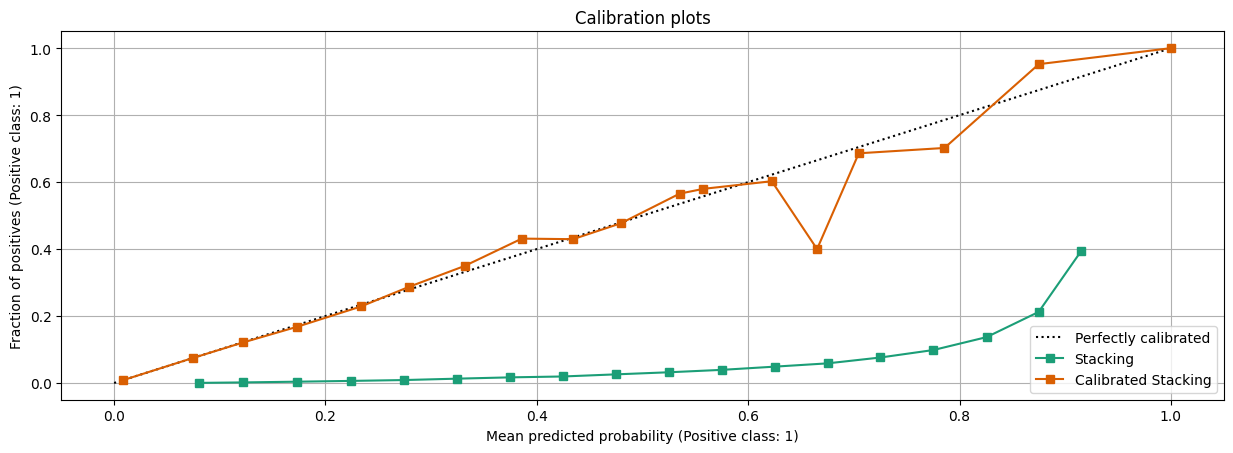

In [215]:
clf_list = [("Stacking", clf), ("Calibrated Stacking", clb_clf)]
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (name, clf_) in enumerate(clf_list):
    y_prob = clf_.predict_proba(X_train_)[:, 1]
    display = CalibrationDisplay.from_predictions(
        y_train_,
        y_prob,
        n_bins=20,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

In [9]:
metrics_estimation(
    clb_clf,
    X_train,
    y_train,
    X_test,
    y_test,
    weeks_train,
    weeks_test,
    name="Stacking_calibrated",
)

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,gini_stability,"overfitting, %"
model,,,,,,,,
Stacking_calibrated_train,0.968933,0.904080,0.624040,0.029613,0.056543,0.098579,0.795425,5.238701
Stacking_calibrated_test,0.968539,0.859075,0.491184,0.020315,0.039016,0.114749,0.691429,5.238701


# Вывод

Составлены ансамблевые модели Voting, Blending, Stacking классификаторов. По сравнению с одиночными моделями Stacking позволяет улучшить метрику ROC_AUC на 0.2156, а gini_stability на 0.3072, что можно назвать хорошим результатом.

В качестве лучшей полученной модели возьмем Stacking_4_rnd_states. Модель получена с помощью класса StackingClassifierCustom с 3 baseline моделями и 12 CatBoost, LightGBM, XGBoost моделями с лучшими гиперпараметрами с разными random_state. Эта модель позволяет получить в результате значения метрик ROC_AUC (0.859422), F1_score (0.179271) и gini_stability (0.692689) выше остальных.